### In this file, I'm going to build a CNN model to classify audio genres.

**IMPORTING LIBRARIES**

In [214]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import random
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import seaborn as sns
import seaborn as sns
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from sklearn.metrics import classification_report

# `preprocess_and_load` Function

## Description
The `preprocess_and_load` function processes audio files from multiple genres, converts them into normalized log-scaled Mel spectrograms suitable for CNN input, and visualizes a random spectrogram to verify correctness.

   **Process Each Audio File**:
   - Load each `.wav` file with a fixed sample rate and duration.
   - Pad or truncate the audio to ensure consistent length.
   - Generate a Mel spectrogram using `librosa`.
   - Convert the spectrogram to decibel (log) scale.
   - Normalize the spectrogram to have zero mean and unit variance.
   - Append the normalized spectrogram and its label to the respective lists.

   **Return Processed Data**:
   - `spectrograms`: Array of Mel spectrograms.
   - `labels`: Array of numerical labels.
   - `genre_names`: List of genre names corresponding to labels.


C:\Users\-\AppData\Local\Temp\ipykernel_32120\1498276064.py:21: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sample_rate, duration=30)


Error processing data/genres_original/jazz\jazz.00054.wav: 


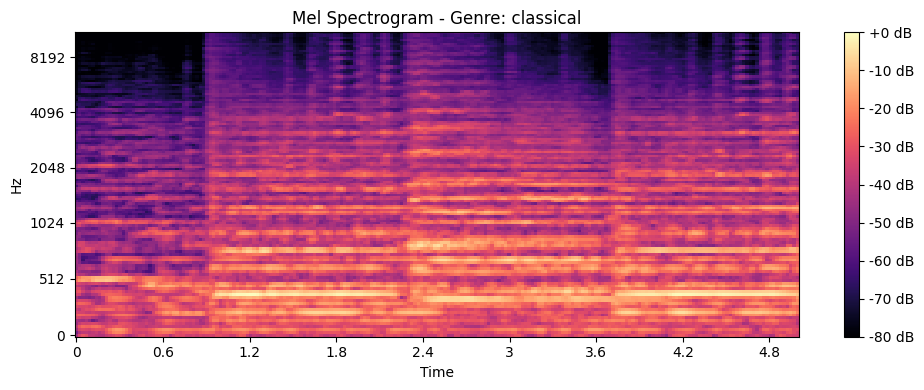

Processed 5985 files across 10 genres.
Shape of spectrograms: (5985, 128, 216, 1)


In [201]:
def preprocess_and_load(base_directory, sample_rate=22050):
    spectrograms = []
    labels = []
    genre_names = []
    
    # Calculate samples for 5 seconds
    samples_per_segment = 5 * sample_rate
    
    genres = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]
    genres.sort()
    
    for label, genre in enumerate(genres):
        genre_dir = os.path.join(base_directory, genre)
        genre_names.append(genre)
        
        for file in os.listdir(genre_dir):
            if file.lower().endswith('.wav'):
                file_path = os.path.join(genre_dir, file)
                try:
                    # Load 30 seconds of audio
                    y, sr = librosa.load(file_path, sr=sample_rate, duration=30)
                    
                    # Split into 5-second segments
                    for i in range(0, len(y), samples_per_segment):
                        segment = y[i:i + samples_per_segment]
                        if len(segment) == samples_per_segment:  # Only use complete segments
                            # Create mel spectrogram with default parameters
                            mel_spect = librosa.feature.melspectrogram(y=segment, sr=sr)
                            mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
                            
                            spectrograms.append(mel_spect_db)
                            labels.append(label)
                            
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    
    spectrograms = np.array(spectrograms)[..., np.newaxis]
    labels = np.array(labels)
    
    # Plot a random spectrogram
    if spectrograms.size > 0:
        idx = random.randint(0, spectrograms.shape[0] - 1)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(spectrograms[idx].squeeze(), sr=sample_rate, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram - Genre: {genre_names[labels[idx]]}')
        plt.tight_layout()
        plt.show()
    
    return spectrograms, labels, genre_names

# Usage
base_dataset_directory = "data/genres_original/"
mel_spectrograms, labels, genre_names = preprocess_and_load(base_dataset_directory)

print(f"Processed {mel_spectrograms.shape[0]} files across {len(genre_names)} genres.")
print(f"Shape of spectrograms: {mel_spectrograms.shape}")

The preprocessing is done. Now we can build the CNN model with Pytorch


In [202]:
# Import PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm


print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


In [203]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device



'cuda'

In [204]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(mel_spectrograms, labels, test_size=0.2, random_state=69)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((4788, 128, 216, 1), (1197, 128, 216, 1), (4788,), (1197,))

In [205]:
# Convert the data to tensors
X_train = torch.from_numpy(X_train).permute(0, 3, 1, 2).to(device)  # Reshape to [batch, channel, height, width]
X_test = torch.from_numpy(X_test).permute(0, 3, 1, 2).to(device)
y_train = torch.from_numpy(y_train).long().to(device)
y_test = torch.from_numpy(y_test).long().to(device)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape



(torch.Size([4788, 1, 128, 216]),
 torch.Size([1197, 1, 128, 216]),
 torch.Size([4788]),
 torch.Size([1197]))

In [206]:
X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype


(torch.float32, torch.float32, torch.int64, torch.int64)

In [207]:
# DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape



(torch.Size([32, 1, 128, 216]), torch.Size([32]))

In [208]:
# See Dataloader content
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [209]:
def train_step(model, dataLoader, loss_fn, optimizer, accuracy_fn, device=device):
    train_loss, train_acc = 0, 0
    model.train()
    
    # Use tqdm for progress bar
    for batch, (X, y) in enumerate(tqdm(dataLoader)):
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Accumulate metrics
        train_loss += loss.item()
        acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        train_acc += acc
        
    # Calculate average loss and accuracy
    train_loss /= len(dataLoader)
    train_acc /= len(dataLoader)
    
    return train_loss, train_acc

In [210]:
def test_step(model, dataLoader, loss_fn, accuracy_fn, device=device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    
    with torch.inference_mode():
        for X, y in dataLoader:
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            test_pred = model(X)
            
            # Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y).item()  # Add .item()
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1)
            )
        
        # Adjust metrics by dividing by the number of batches
        test_loss /= len(dataLoader)
        test_acc /= len(dataLoader)
        
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")
    
    return test_loss, test_acc

In [211]:
class AudioCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        # First Convolutional Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )
        
        # Second Convolutional Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )
        
        # Third Convolutional Block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )
        
        # Fourth Convolutional Block
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )
        
        # Calculate flatten size dynamically
        self._initialize_flatten_size()
        
        # Fully Connected layers
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def _initialize_flatten_size(self):
        x = torch.randn(1, 1, 128, 216)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        self.flatten_size = x.shape[1] * x.shape[2] * x.shape[3]
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Create model instance
model = AudioCNN(num_classes=len(genre_names))
model = model.to(device)



In [212]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005, weight_decay=1e-4)


Epoch 1
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 2.88913 | Test accuracy: 17.47%
Epoch 2
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 2.13220 | Test accuracy: 25.84%
Epoch 3
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 1.51350 | Test accuracy: 45.90%
Epoch 4
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 1.47337 | Test accuracy: 44.43%
Epoch 5
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 1.60267 | Test accuracy: 45.25%
Epoch 6
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 1.53964 | Test accuracy: 47.39%
Epoch 7
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 1.31244 | Test accuracy: 54.00%
Epoch 8
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 1.13544 | Test accuracy: 64.11%
Epoch 9
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 1.10540 | Test accuracy: 62.59%
Epoch 10
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 1.01505 | Test accuracy: 65.92%
Epoch 11
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.92190 | Test accuracy: 69.71%
Epoch 12
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.93898 | Test accuracy: 67.45%
Epoch 13
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.88050 | Test accuracy: 69.29%
Epoch 14
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 1.11759 | Test accuracy: 64.81%
Epoch 15
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.98704 | Test accuracy: 67.15%
Epoch 16
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.91120 | Test accuracy: 70.86%
Epoch 17
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 1.14040 | Test accuracy: 62.35%
Epoch 18
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.73510 | Test accuracy: 76.25%
Epoch 19
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.81362 | Test accuracy: 73.08%
Epoch 20
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.82974 | Test accuracy: 71.10%
Epoch 21
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.81701 | Test accuracy: 72.33%
Epoch 22
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.71870 | Test accuracy: 75.79%
Epoch 23
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.97719 | Test accuracy: 68.19%
Epoch 24
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.61146 | Test accuracy: 80.23%
Epoch 25
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.65932 | Test accuracy: 77.44%
Epoch 26
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.55787 | Test accuracy: 81.71%
Epoch 27
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.65161 | Test accuracy: 78.09%
Epoch 28
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.70457 | Test accuracy: 78.05%
Epoch 29
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.63236 | Test accuracy: 79.61%
Epoch 30
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.71809 | Test accuracy: 78.75%
Epoch 31
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.62953 | Test accuracy: 78.42%
Epoch 32
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.58382 | Test accuracy: 79.90%
Epoch 33
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.55020 | Test accuracy: 82.77%
Epoch 34
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.59560 | Test accuracy: 79.65%
Epoch 35
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.58546 | Test accuracy: 81.91%
Epoch 36
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.52415 | Test accuracy: 83.27%
Epoch 37
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.54162 | Test accuracy: 82.77%
Epoch 38
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.55239 | Test accuracy: 82.77%
Epoch 39
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.51607 | Test accuracy: 83.60%
Epoch 40
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.56443 | Test accuracy: 82.57%
Epoch 41
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.48699 | Test accuracy: 85.32%
Epoch 42
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.54001 | Test accuracy: 82.98%
Epoch 43
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.56463 | Test accuracy: 82.15%
Epoch 44
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.46897 | Test accuracy: 84.46%
Epoch 45
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.47705 | Test accuracy: 84.87%
Epoch 46
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.52469 | Test accuracy: 83.60%
Epoch 47
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.65693 | Test accuracy: 79.07%
Epoch 48
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.58209 | Test accuracy: 82.20%
Epoch 49
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.43642 | Test accuracy: 86.39%
Epoch 50
-------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Test loss: 0.43385 | Test accuracy: 85.82%


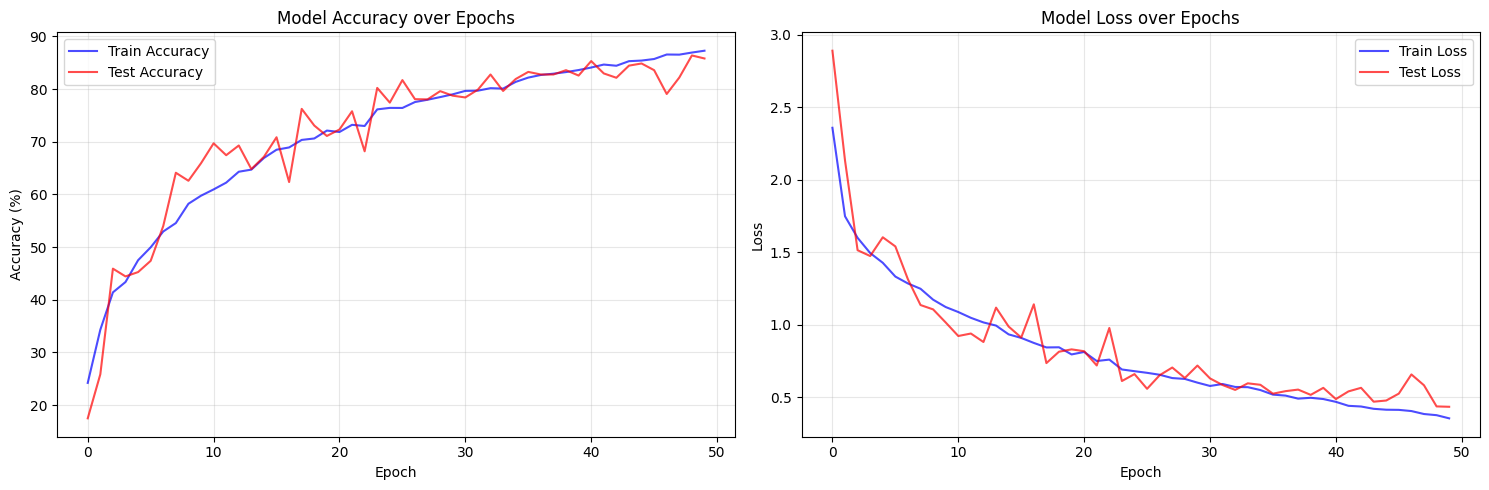


Best Test Accuracy: 86.39% (Epoch 49)
Final Test Accuracy: 85.82%


In [213]:
# Lists to store metrics
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

# Training the Model
torch.manual_seed(69)

epochs = 50
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    
    # Training
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn)
    train_accuracies.append(train_acc)
    train_losses.append(train_loss)
            
    # Testing
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn, accuracy_fn)
    test_accuracies.append(test_acc)
    test_losses.append(test_loss)

# Plotting
plt.figure(figsize=(15, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', color='blue', alpha=0.7)
plt.plot(test_accuracies, label='Test Accuracy', color='red', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy over Epochs')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', color='blue', alpha=0.7)
plt.plot(test_losses, label='Test Loss', color='red', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss over Epochs')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best accuracy achieved
best_test_acc = max(test_accuracies)
best_epoch = test_accuracies.index(best_test_acc) + 1
print(f"\nBest Test Accuracy: {best_test_acc:.2f}% (Epoch {best_epoch})")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")

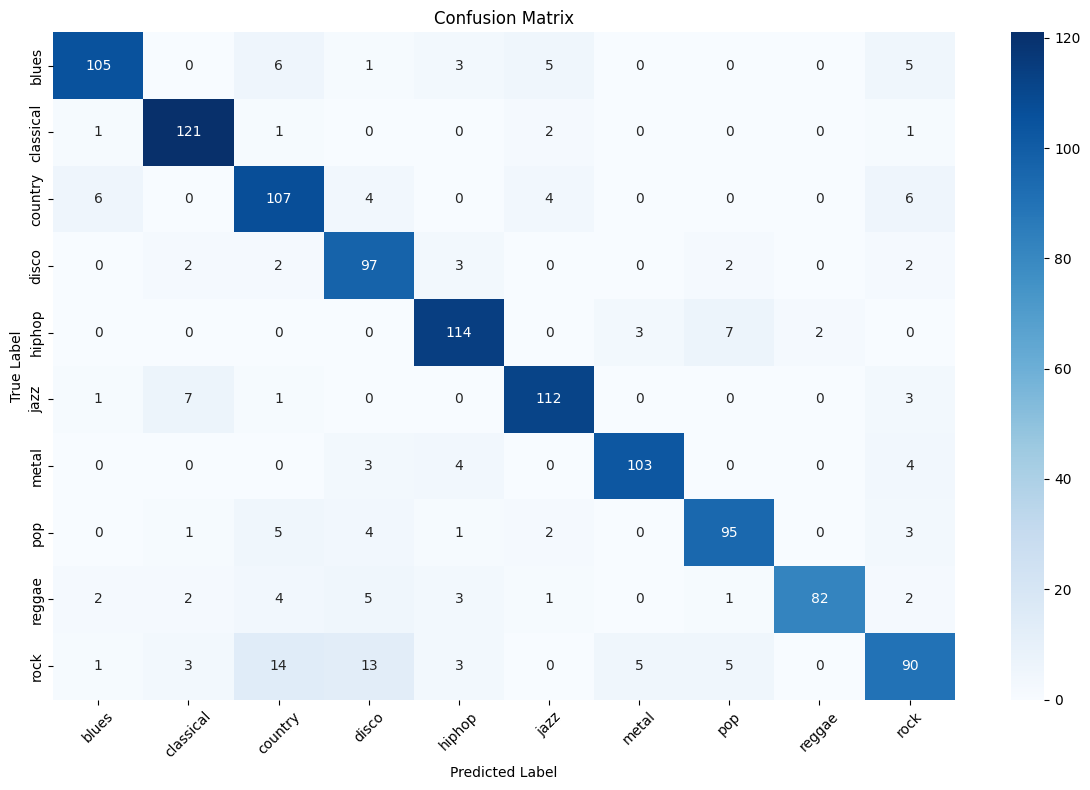


Classification Report:
              precision    recall  f1-score   support

       blues       0.91      0.84      0.87       125
   classical       0.89      0.96      0.92       126
     country       0.76      0.84      0.80       127
       disco       0.76      0.90      0.83       108
      hiphop       0.87      0.90      0.89       126
        jazz       0.89      0.90      0.90       124
       metal       0.93      0.90      0.92       114
         pop       0.86      0.86      0.86       111
      reggae       0.98      0.80      0.88       102
        rock       0.78      0.67      0.72       134

    accuracy                           0.86      1197
   macro avg       0.86      0.86      0.86      1197
weighted avg       0.86      0.86      0.86      1197



In [219]:


def plot_confusion_matrix(model, test_dataloader, class_names):
    y_pred_list = []
    y_true_list = []

    model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            y_pred_list.extend(y_pred.argmax(dim=1).cpu().numpy())
            y_true_list.extend(y.cpu().numpy())

    # Create confusion matrix using sklearn's function
    cm = sk_confusion_matrix(y_true=y_true_list, y_pred=y_pred_list)
    
    # Plot
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true_list, y_pred_list, target_names=class_names))

# Plot confusion matrix
plot_confusion_matrix(model, test_dataloader, genre_names)

In [222]:
torch.save(model, "complete_CNN_model.pth")
